# About
#### Last updated June 2025
This notebook generates the panels reported in Fig. S8

* NB: In June 2025 we identified a small indexing error in the SHD algorithm. Fixing this led to a small but unimportant change in the correlation and RMSE between the Zeng et al. Rg prediction vs. SAXS. For completeness, the original values reported in the Feb. 2024 version of the paper are retained as `all_comparison_data_2024.csv`. However, when run with a fresh install this notebook will use the corrected SHD implementation in sparrow, generating the data in `all_comparison_data.csv`.
* For completeness, the original $r^2$ and RMSE values when comparing SAXS with the SCD/SHD-dependent $\rm{R_g}$ values were $r^2 = 0.08$  and $\rm{RMSE} = 13.7 $Å. After the indexing fix, these values change to $r^2 = 0.035$  and $\rm{RMSE} = 16.21 $Å, but in both cases, the point of this comparison is that this particular approach to estimating experimental values is not particularly accurate.
* It is – however – worth noting the limits of this prediction developed by Zheng et al were never designed as a tool to directly predict SAXS data, but instead to show that using these two parameters simple polymer models offered a good ability to predict $\rm{R_g}$ and $\nu$ from sequence in the limit of the HPS model. So, although the predictive power here with respect to experimental data is not great, this is moot given the actual goal of this (excellent) work by Zeng et al. We include this disclaimer for completeness! 

In [3]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from afrc import AnalyticalFRC
from sparrow import Protein
from shephard import interfaces, apis

from scipy.signal import savgol_filter
import metapredict as meta
from sparrow.data.amino_acids import VALID_AMINO_ACIDS
import pandas as pd

In [4]:
# read in SAXS data
data = pd.read_csv('data/saxs_data.csv')

In [5]:
# read in the sequences
seqs = {}
for index, row in data.iterrows():
    
    n = row['Name']
    s = row['seq']
    
    seqs[n] = s

In [6]:
# read in predictsions made using the IDPGan notebook online
IDPgan = pd.read_csv('data/idpgan_results.csv')

# read in predictsion made using the CALVADOS2 predictions online
CALVADOS2 = pd.read_csv('data/CALVADOS2_SAXS_Sequences.csv')

### Predict / extract IDR dimensions from ALBATROSS and pre-computed values
For ALBATROSS predictions this takes ~5 seconds for 137 sequences, although if done in batch this would be substantially faster.


In [7]:
%%time

LAMMPS_rg = []
SAXS_rg = []
rg_prediction = {}
name2idx = {}
idx2name= {}
rg_prediction['ALBATROSS'] = []
rg_prediction['Zheng'] = []
rg_prediction['IDPGan'] = []
rg_prediction['AFRC'] = []
rg_prediction['CALVADOS2'] = []
for index, row in data.iterrows():
    
    prot_name = row['Name']
    
    name2idx[prot_name] = index
    idx2name[index] = prot_name
    LAMMPS_rg.append(row['LAMMPS_Rg_NO_ALIG'])
    SAXS_rg.append(row['Experimental_Rg'])
    
    # predict with ALBATROSS
    rg_prediction['ALBATROSS'].append(Protein(row['seq']).predictor.radius_of_gyration(use_scaled=True))
    
    # preddict using the SHD/SCD-based predictor of Zheng et al
    rg_prediction['Zheng'].append(Protein(row['seq']).polymeric.empirical_radius_of_gyration())
    
    # excise out IDPGan predictsion
    x = IDPgan.loc[IDPgan['Protein'] == prot_name, ' Average_Rg']
    rg_prediction['IDPGan'].append(float(x))
    
    # exise out CALVADOS2 predictions and convert to Å
    x = 10*CALVADOS2.loc[CALVADOS2['Name'] == f"{prot_name}_IDRLab", '<Rg> (nm)']
    rg_prediction['CALVADOS2'].append(float(x))
    
    # calculate expected Rg from AFRC. We emphasize this is NOT a prediction of expected dimensions, but 
    # the expected dimensions IF this chain were to behave as a flexible Gaussian chain.
    rg_prediction['AFRC'].append(Protein(row['seq']).polymeric.get_mean_afrc_radius_of_gyration())
    
    
    


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


<timed exec>:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
<timed exec>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


CPU times: user 974 ms, sys: 91.9 ms, total: 1.07 s
Wall time: 1.05 s


In [8]:
def calc_rmse(d1,d2):    
    """
    Function that given two lists or vectors, calculates the root-mean-square error (RMSE)
    between the two input datasets. Assumes both are the same length
    
    Parameters
    -------------
    d1 : list/vector/np.ndarray
        Dataset 1

    d2 : list/vector/np.ndarray
        Dataset 2
        
    Returns
    -------------
    float
        Returns a float which is the RMSE between the two datasets
        

    """
    
    return np.sqrt(np.mean(np.power(np.array(d1) - np.array(d2),2)))


## Save all data plotted in Fig. S8
The cell below generates a nicely-formatted CSV file that contains all the comparison data plotted in Fig. S8. This table provided as table S6 in the Lotthammer/Ginell/Griffth manuscriot. Note that references for all sequences can be found in the supplementary information for [Alston & Ginell et al. J.Phys. Chem. B](https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.3c01619) (Table S4)

In [9]:
with open('all_comparison_data.csv','w') as fh:

    fh.write('index, name, SAXS Rg (A), ALBATROSS Rg (A) [pred], IDPGan Rg (A) [pred], Zheng Rg (A), CALVADOS2 Rg (A) [sim], Mpipi-GG (A) [sim], AFRC Rg (A) [polymer model], sequence\n')

    for k in name2idx:
        local_seq = seqs[k]
        idx = name2idx[k]
                
        outstring = str(idx) + ", "
        outstring = outstring + f"{k}, "
        outstring = outstring + f"{SAXS_rg[idx]}, "
        outstring = outstring + f"{round(rg_prediction['ALBATROSS'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['IDPGan'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['Zheng'][idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['CALVADOS2'][idx],2)}, "
        outstring = outstring + f"{round(LAMMPS_rg[idx],2)}, "
        outstring = outstring + f"{round(rg_prediction['AFRC'][idx],2)}, "
        outstring = outstring + local_seq
    
        outstring = outstring +"\n"

        fh.write(outstring)


## SCD/SHD prediction vs. SAXS
Note that several points fall outside of the range shown here, hence the very low r^2

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/1373889737.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


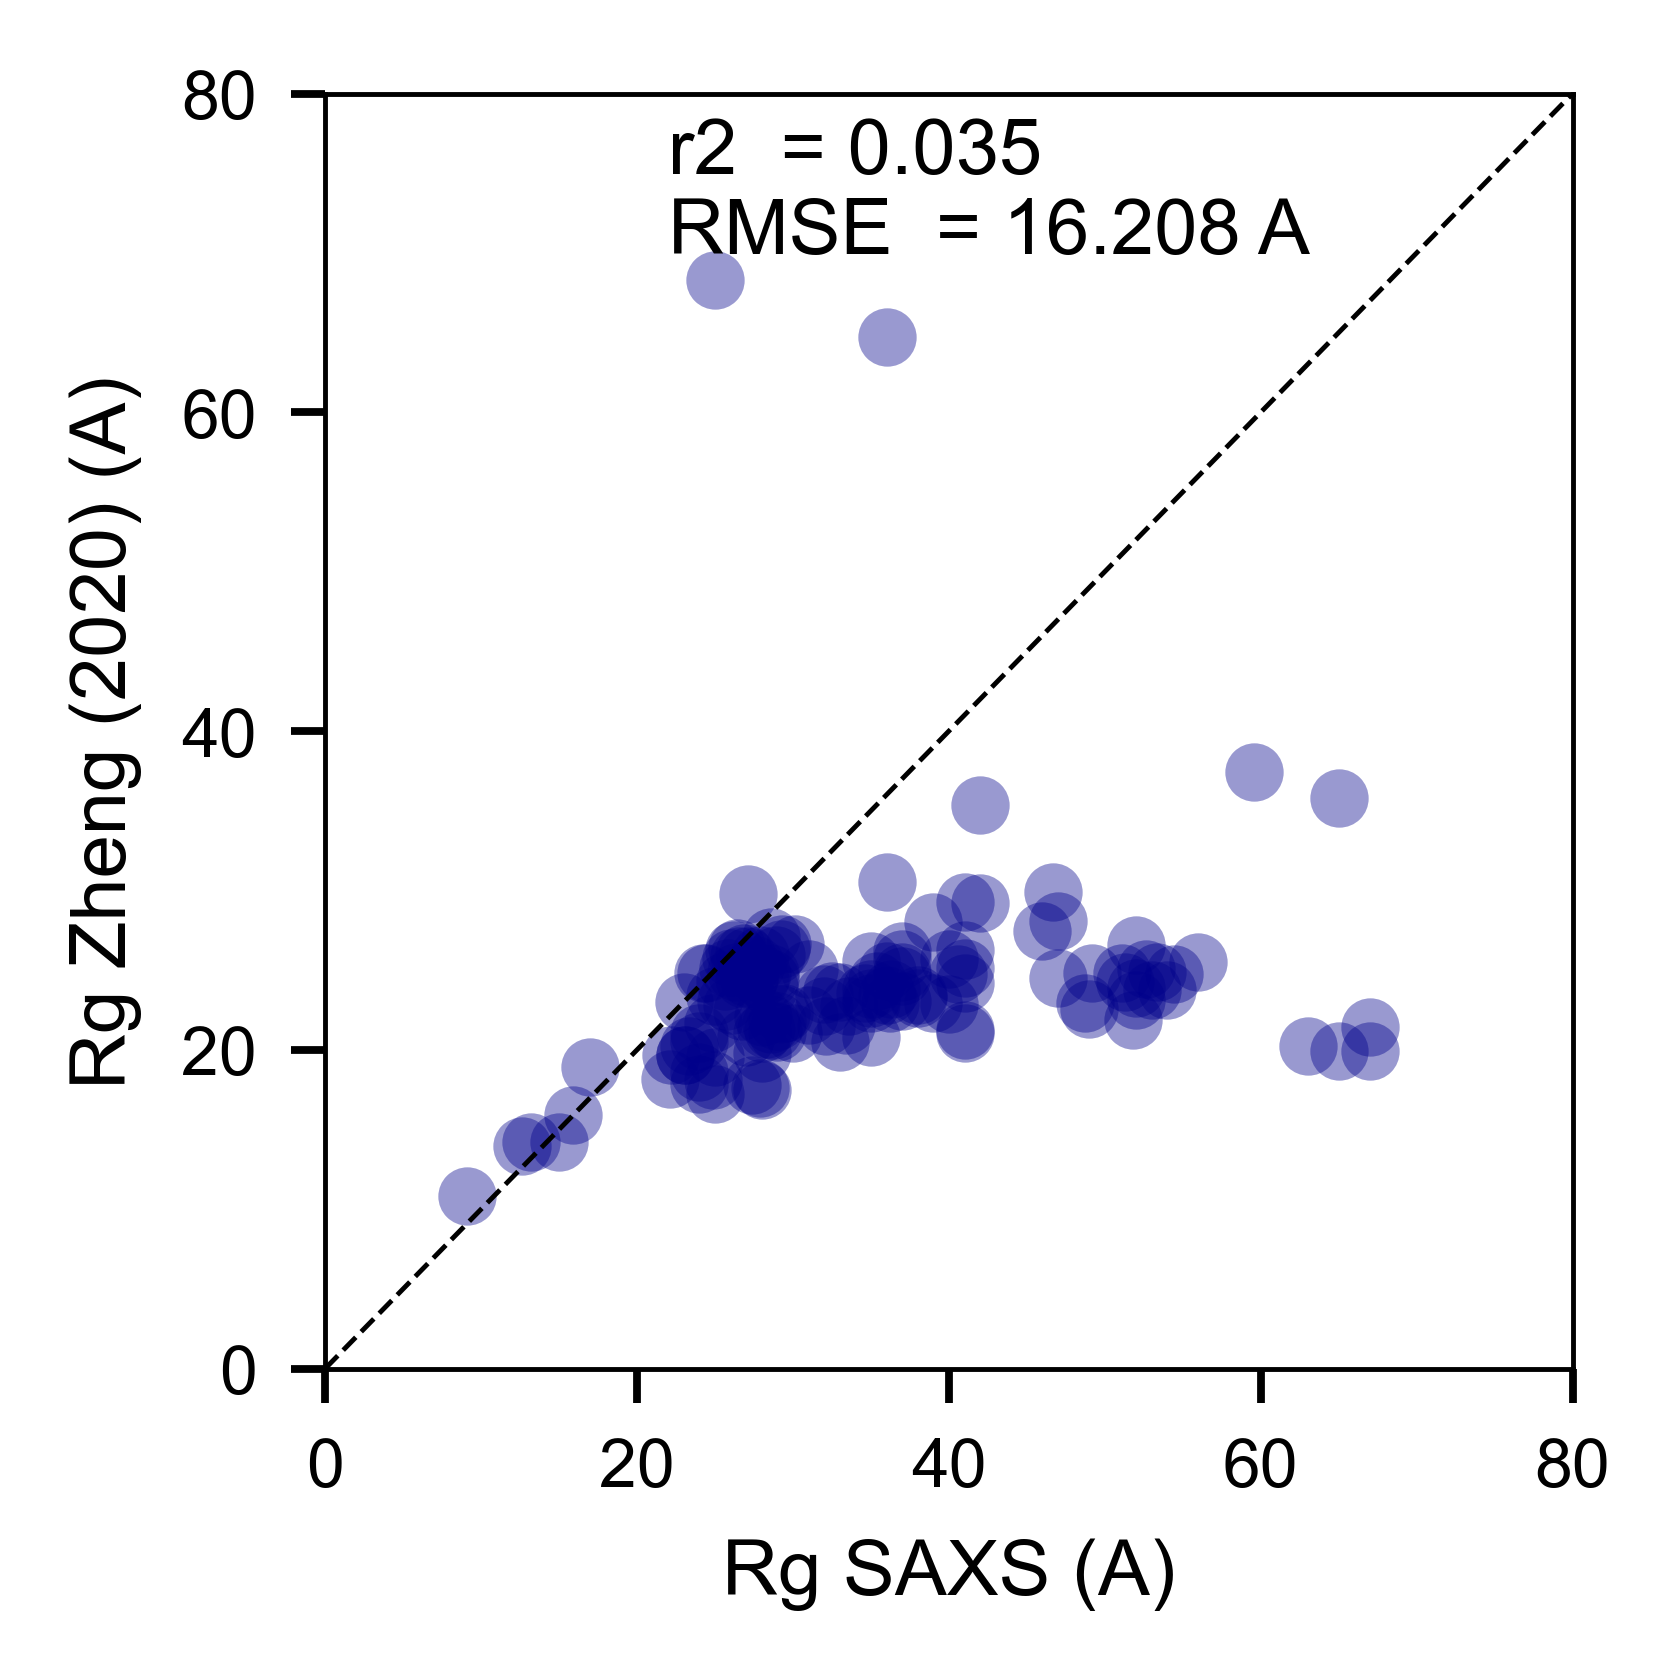

In [10]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng.pdf')


/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/3861906317.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


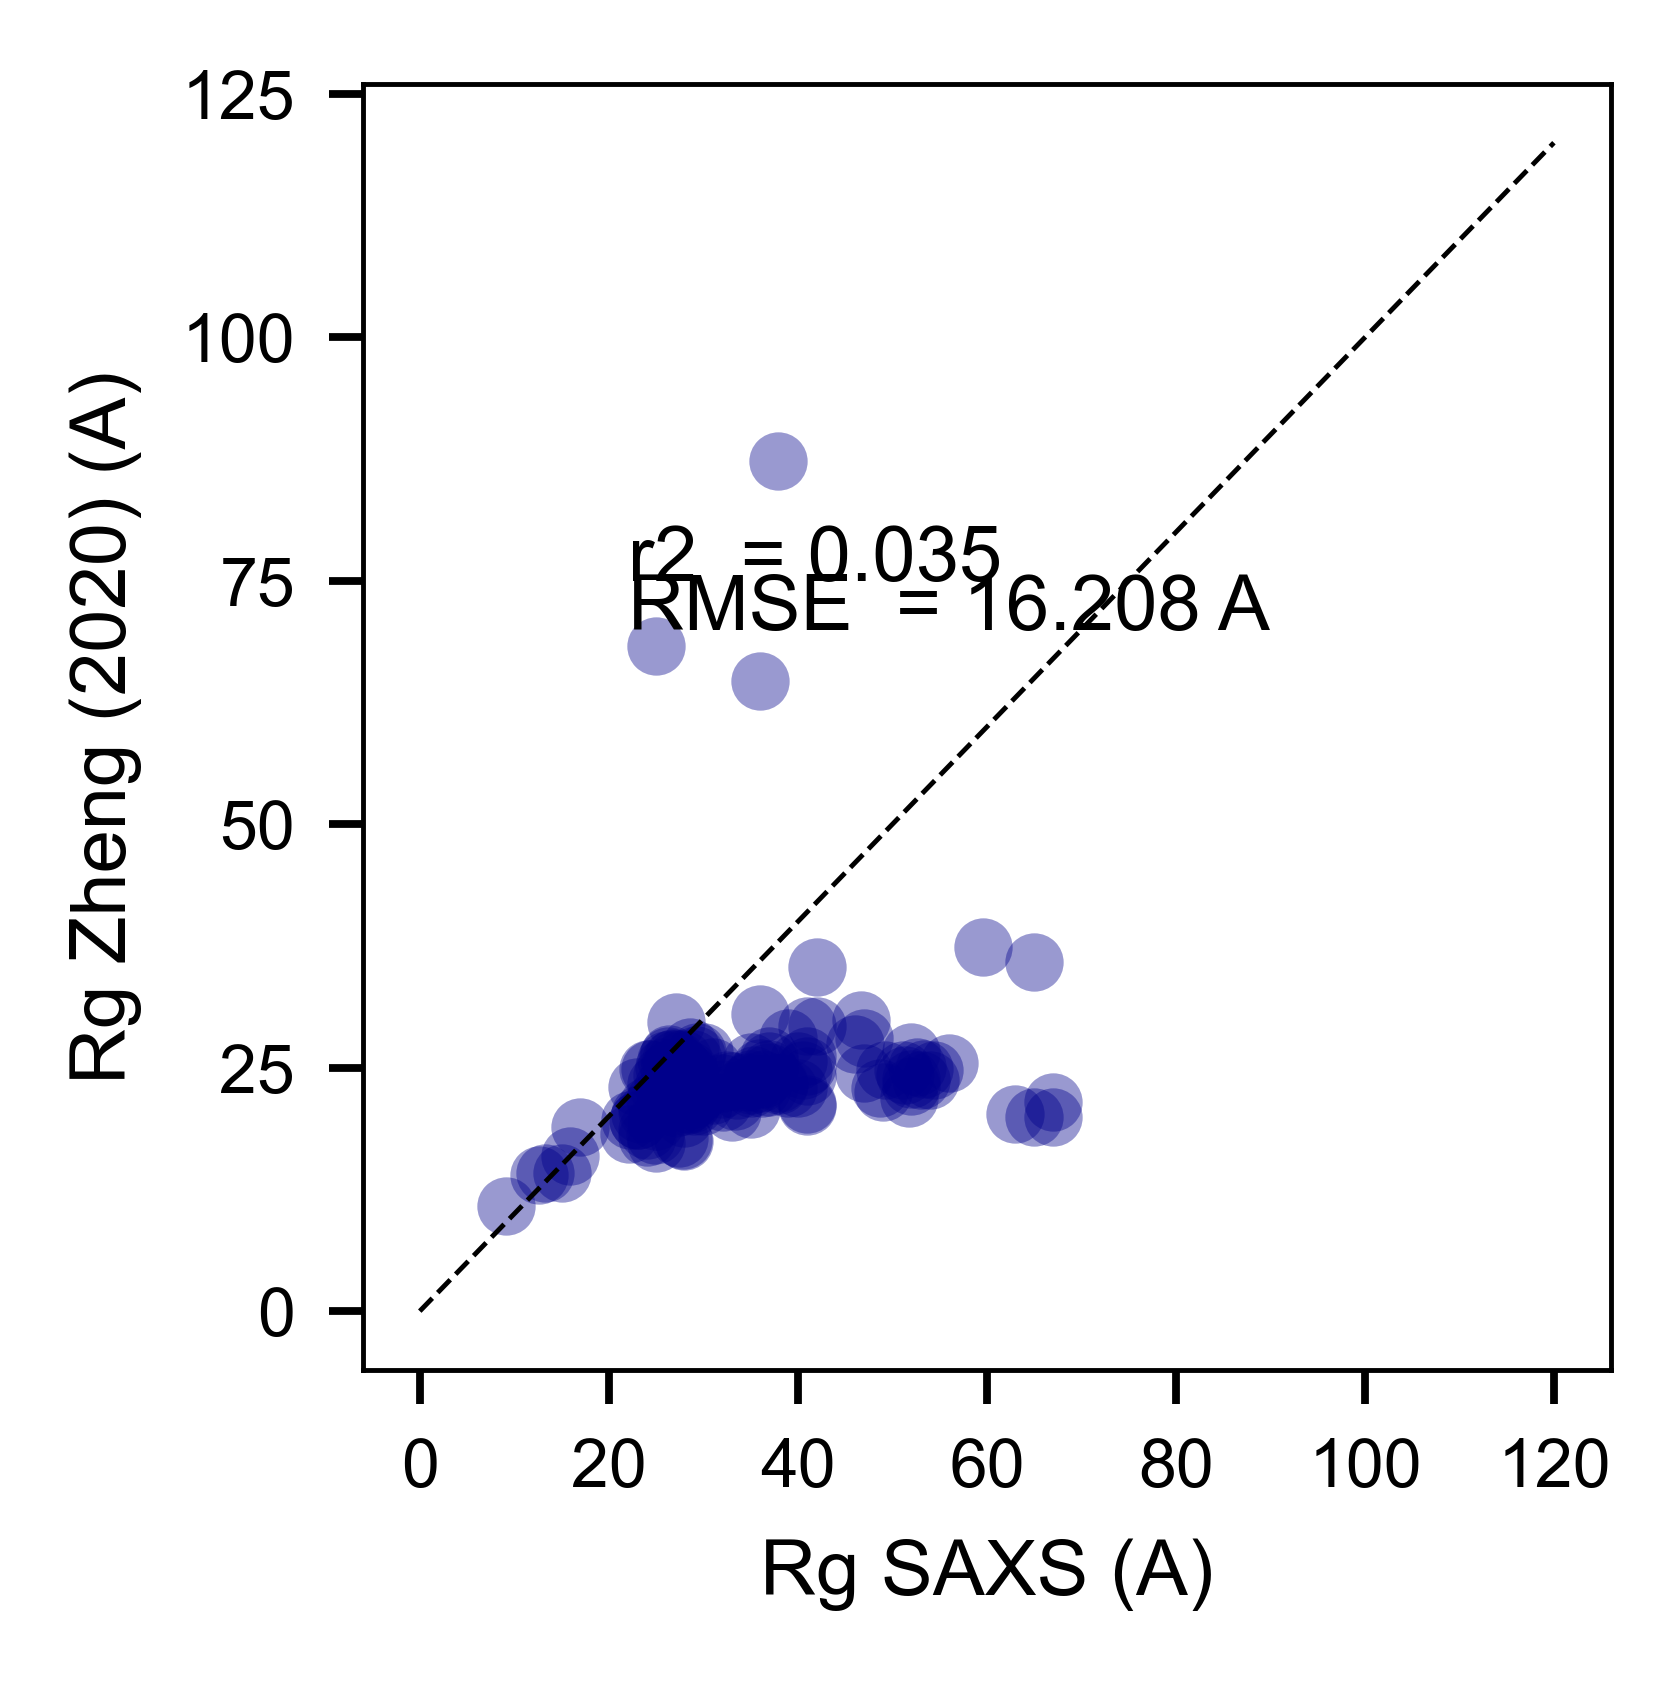

In [11]:
#
# Same as above, but without the ylim/xlim
#

figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
#plt.ylim([0,80])
#plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng_no_lim.pdf')


/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/3220289447.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


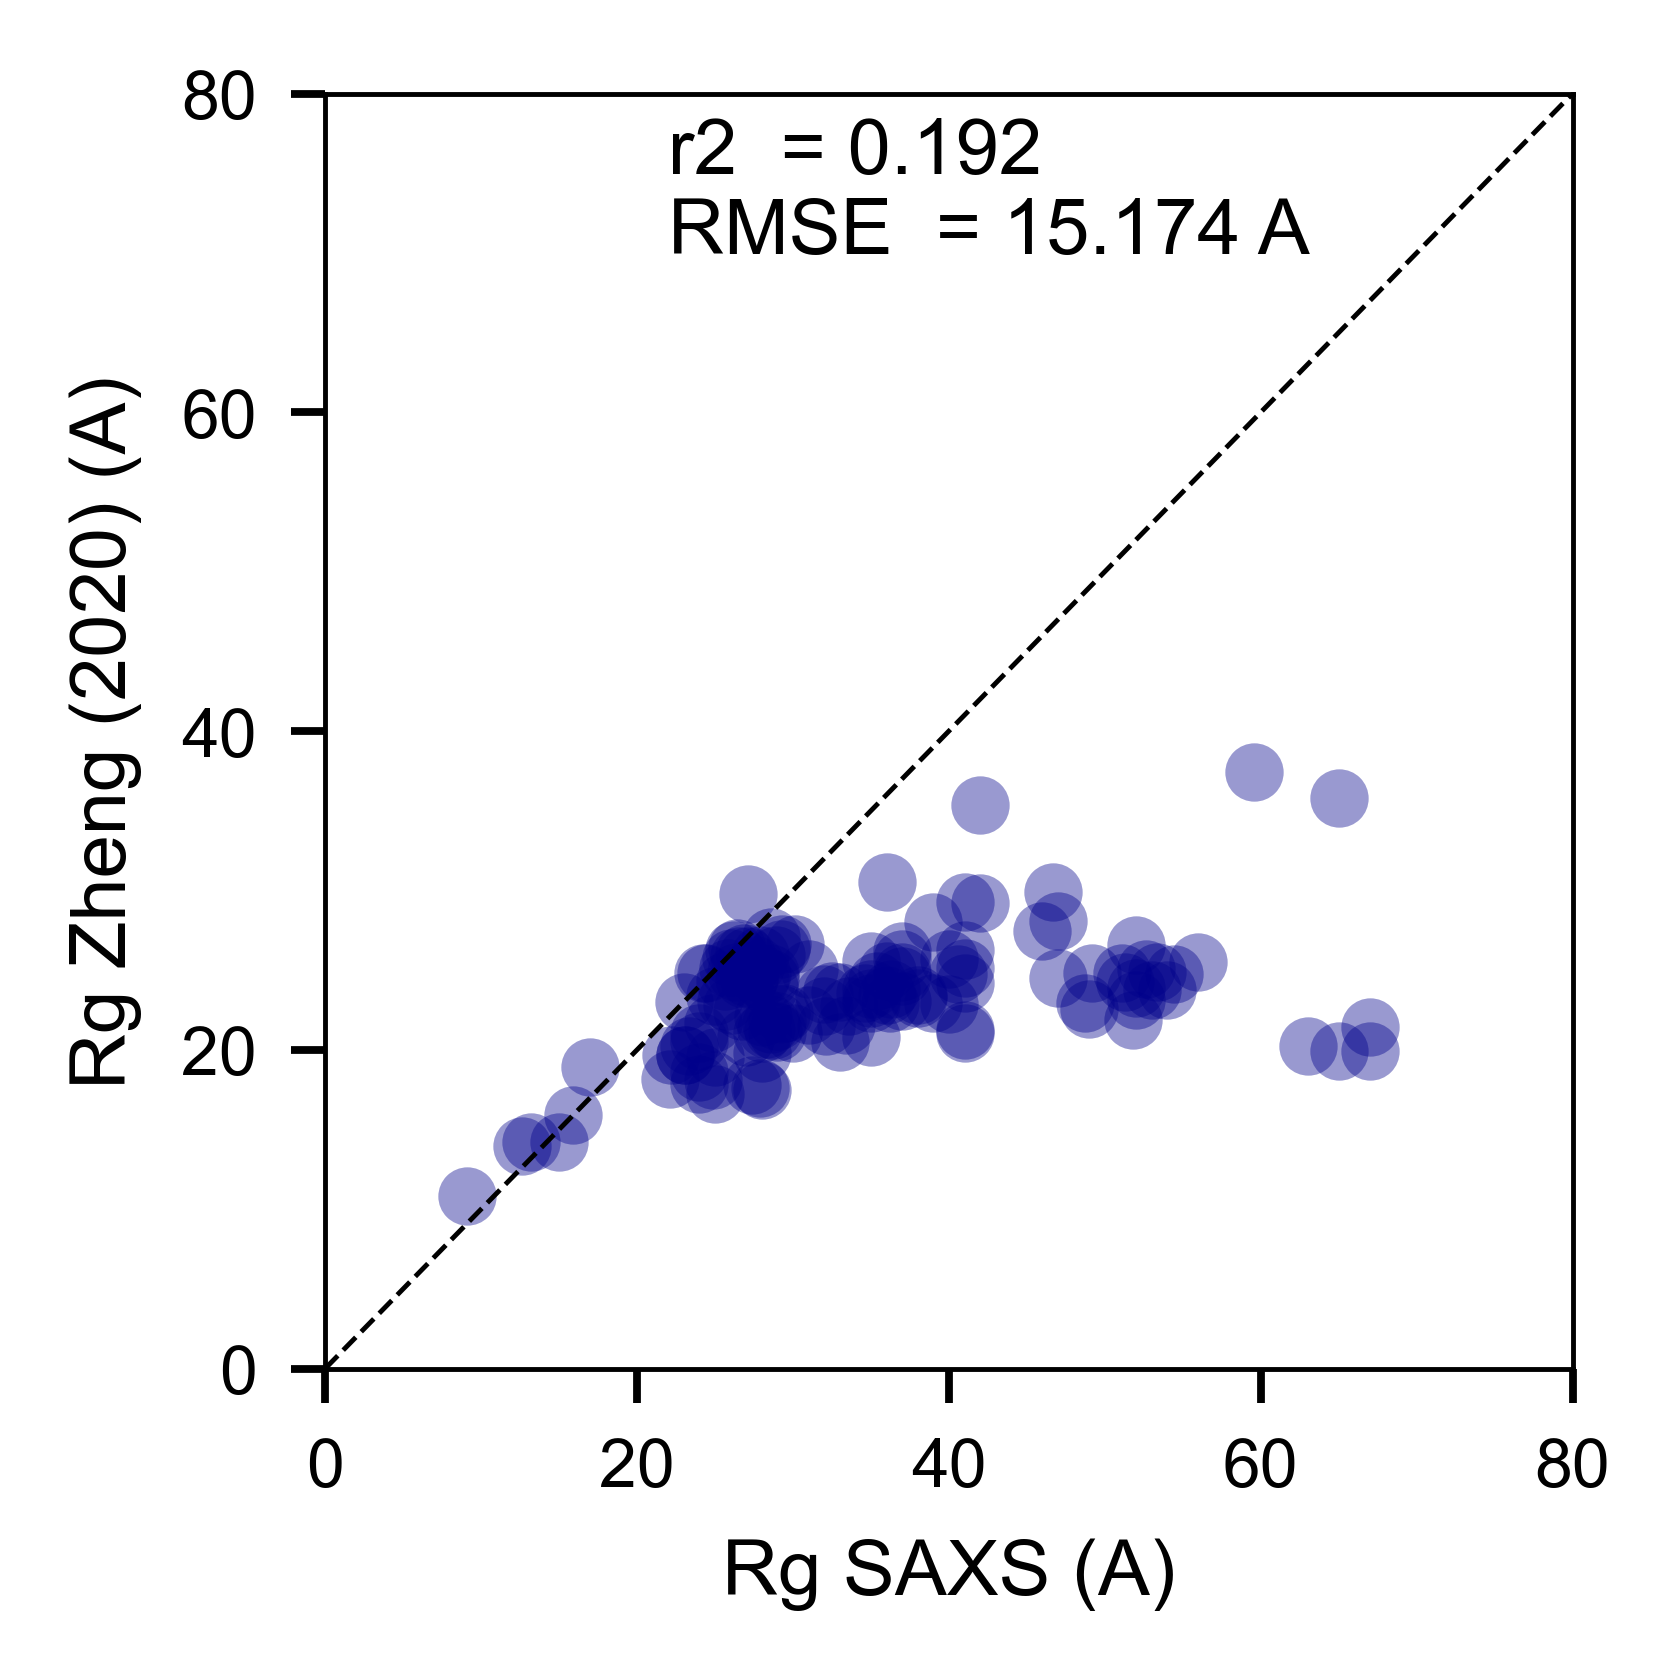

In [14]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg.copy()
d2 = rg_prediction['Zheng'].copy()

# manually remove outliers

# ProtAlpha
d1.pop(69)
d2.pop(69)

#H1_CTD
d1.pop(37)
d2.pop(37)

# Fez1
d1.pop(34)
d2.pop(34)


plt.plot(d1, d2, '.', color='darkblue', ms=12, mew=0, alpha=0.4, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg Zheng (2020) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_Zheng_without_outliers.pdf')


### IDPGAN vs. SAXS

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/4163181378.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


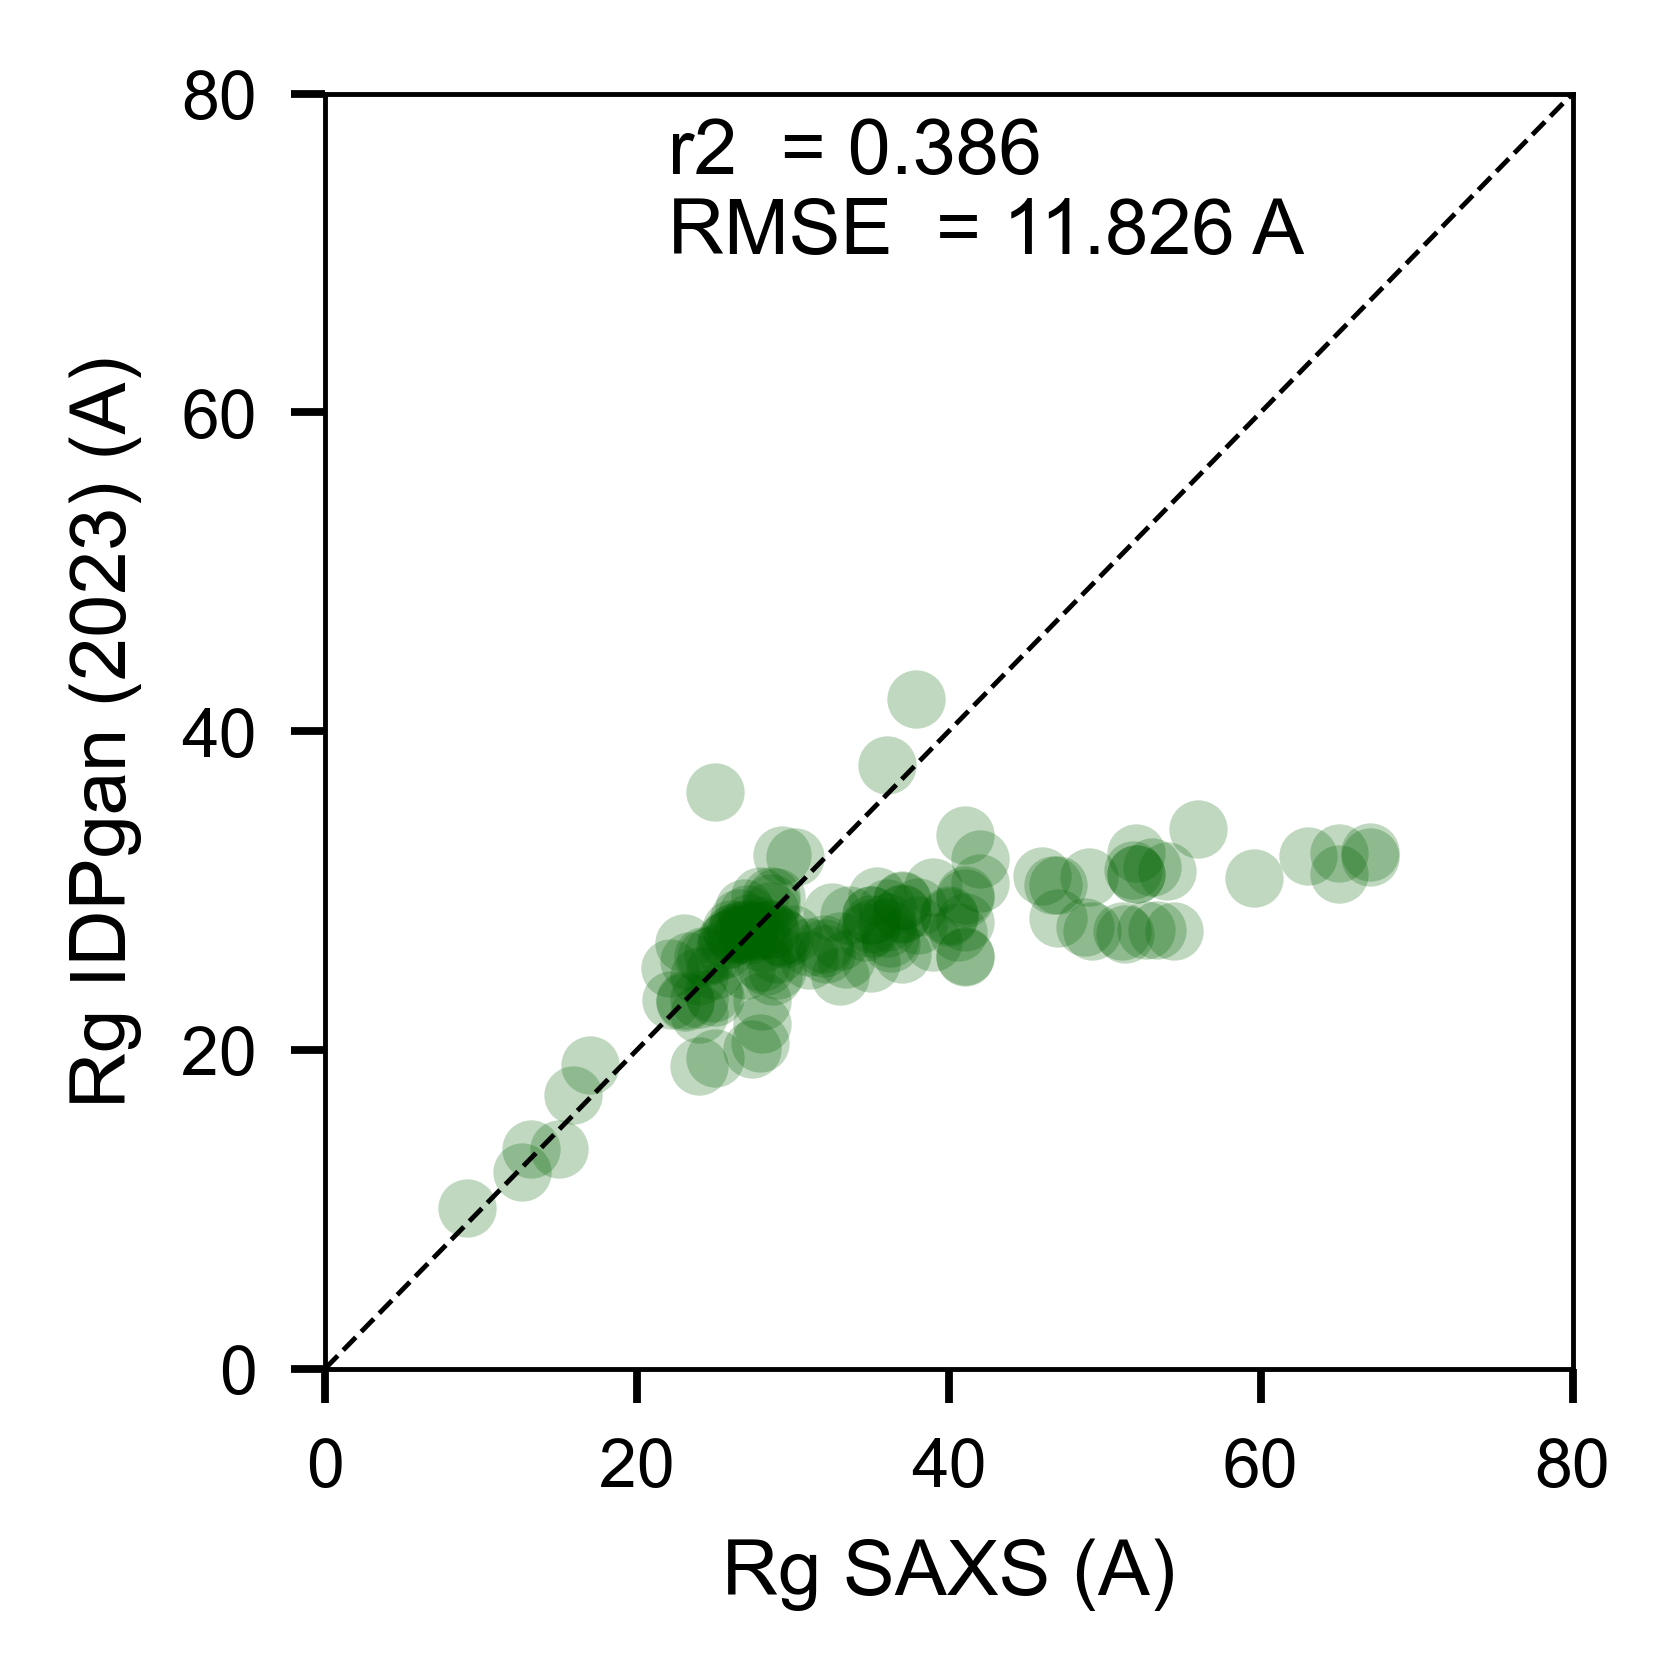

In [15]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['IDPGan']



plt.plot(d1, d2, '.', color='darkgreen', ms=12, mew=0, alpha=0.25, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg IDPgan (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_IDPGan.pdf')


## AFRC vs. SAXS

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/1562688508.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


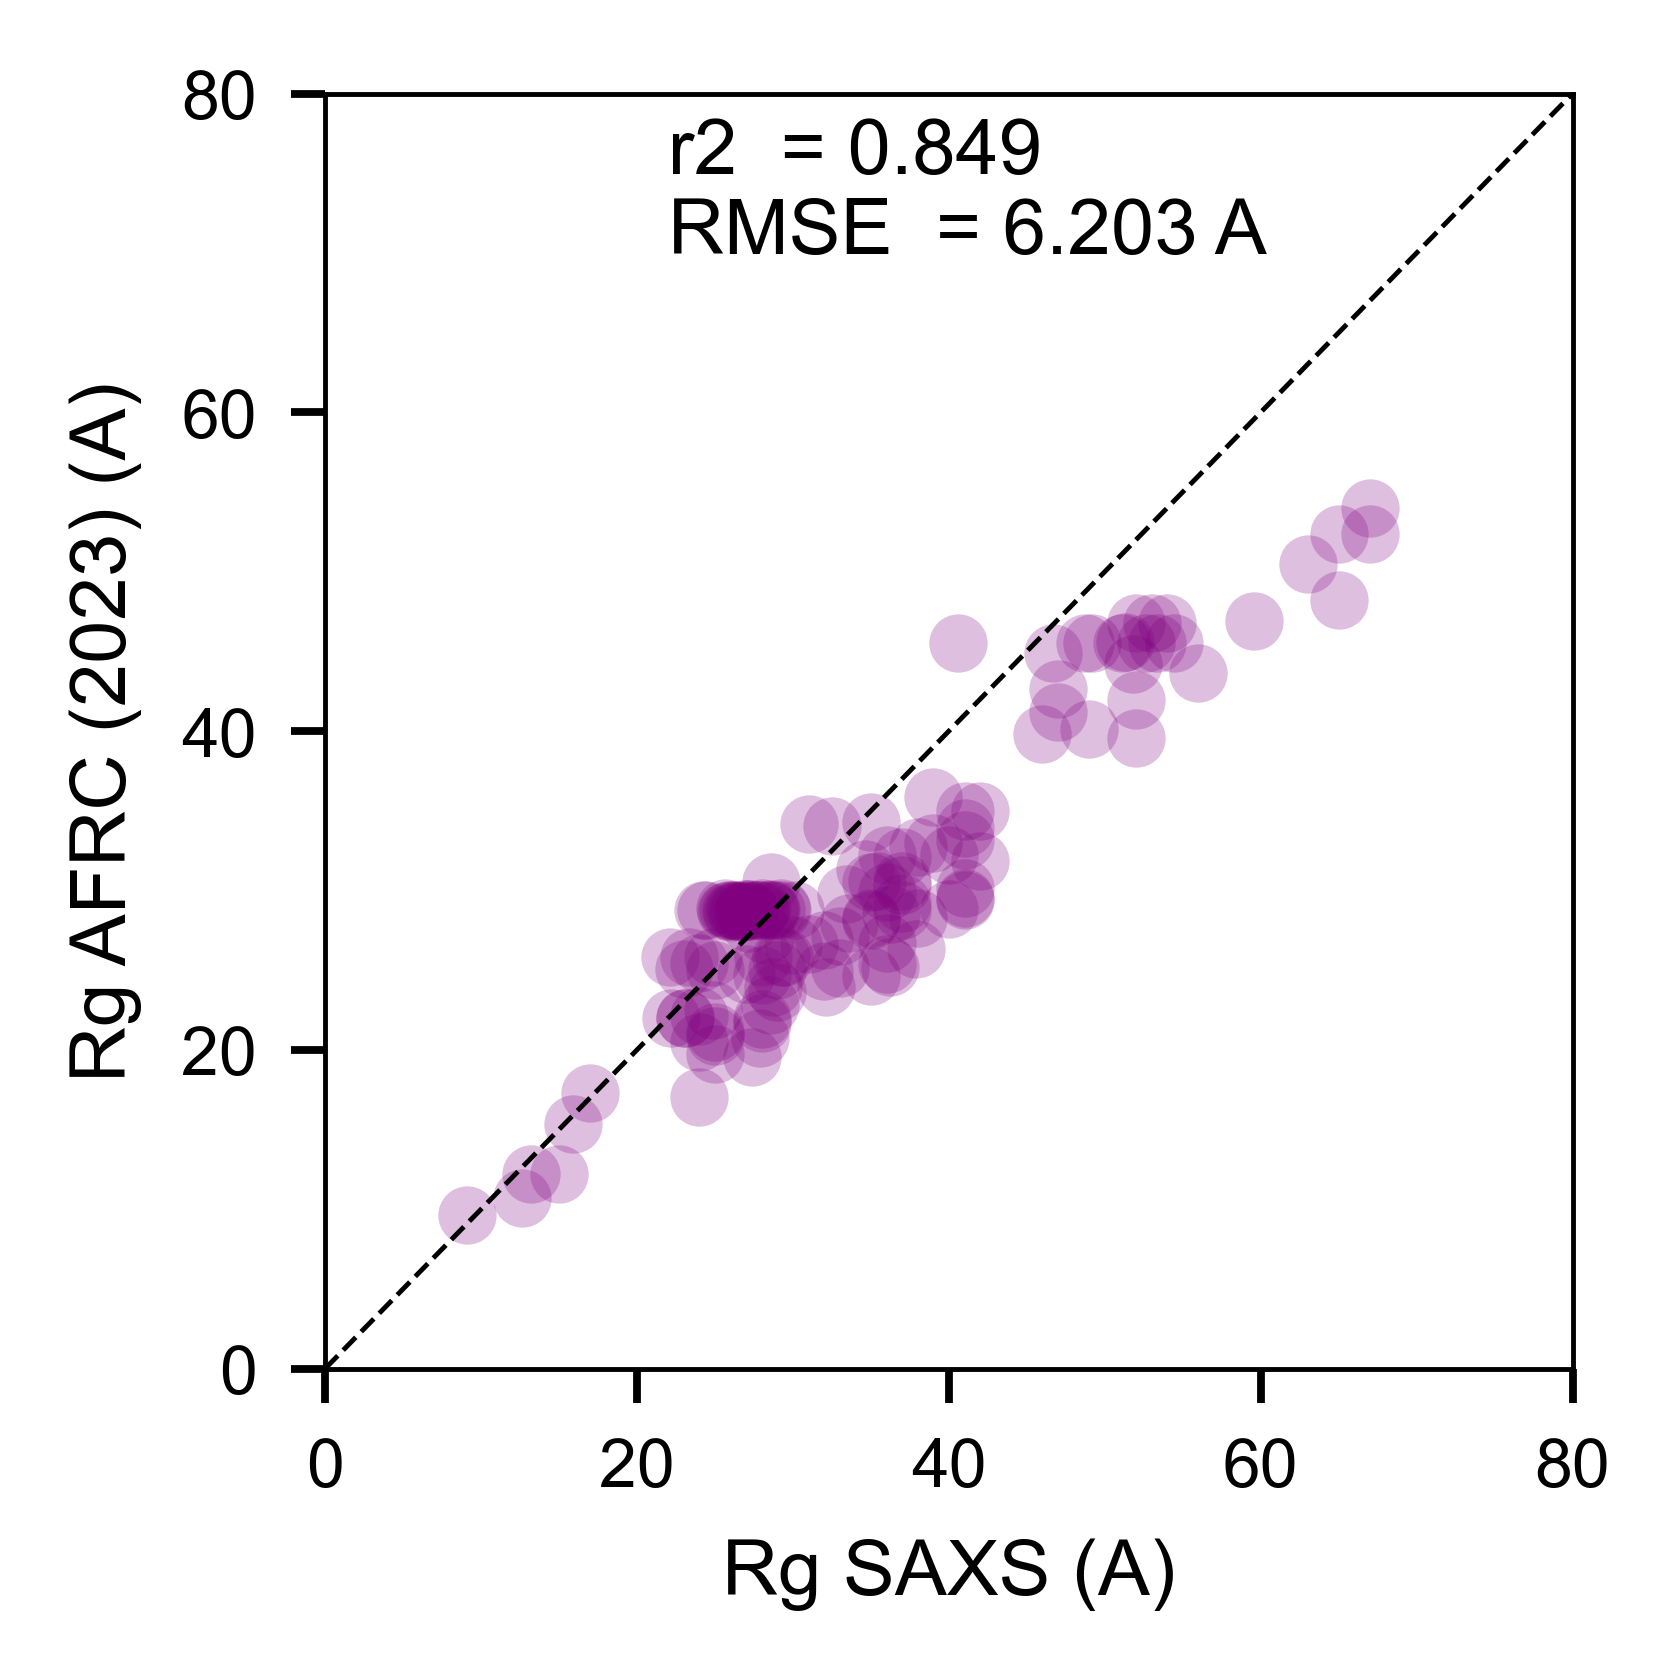

In [16]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['AFRC']

plt.plot(d1, d2, '.', color='purple', ms=12, mew=0, alpha=0.25, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg AFRC (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])

plt.tight_layout()
plt.savefig('rg_SAXS_AFRC.pdf')


In [17]:
## ALBATROSS vs. SAXS

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/2788813305.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


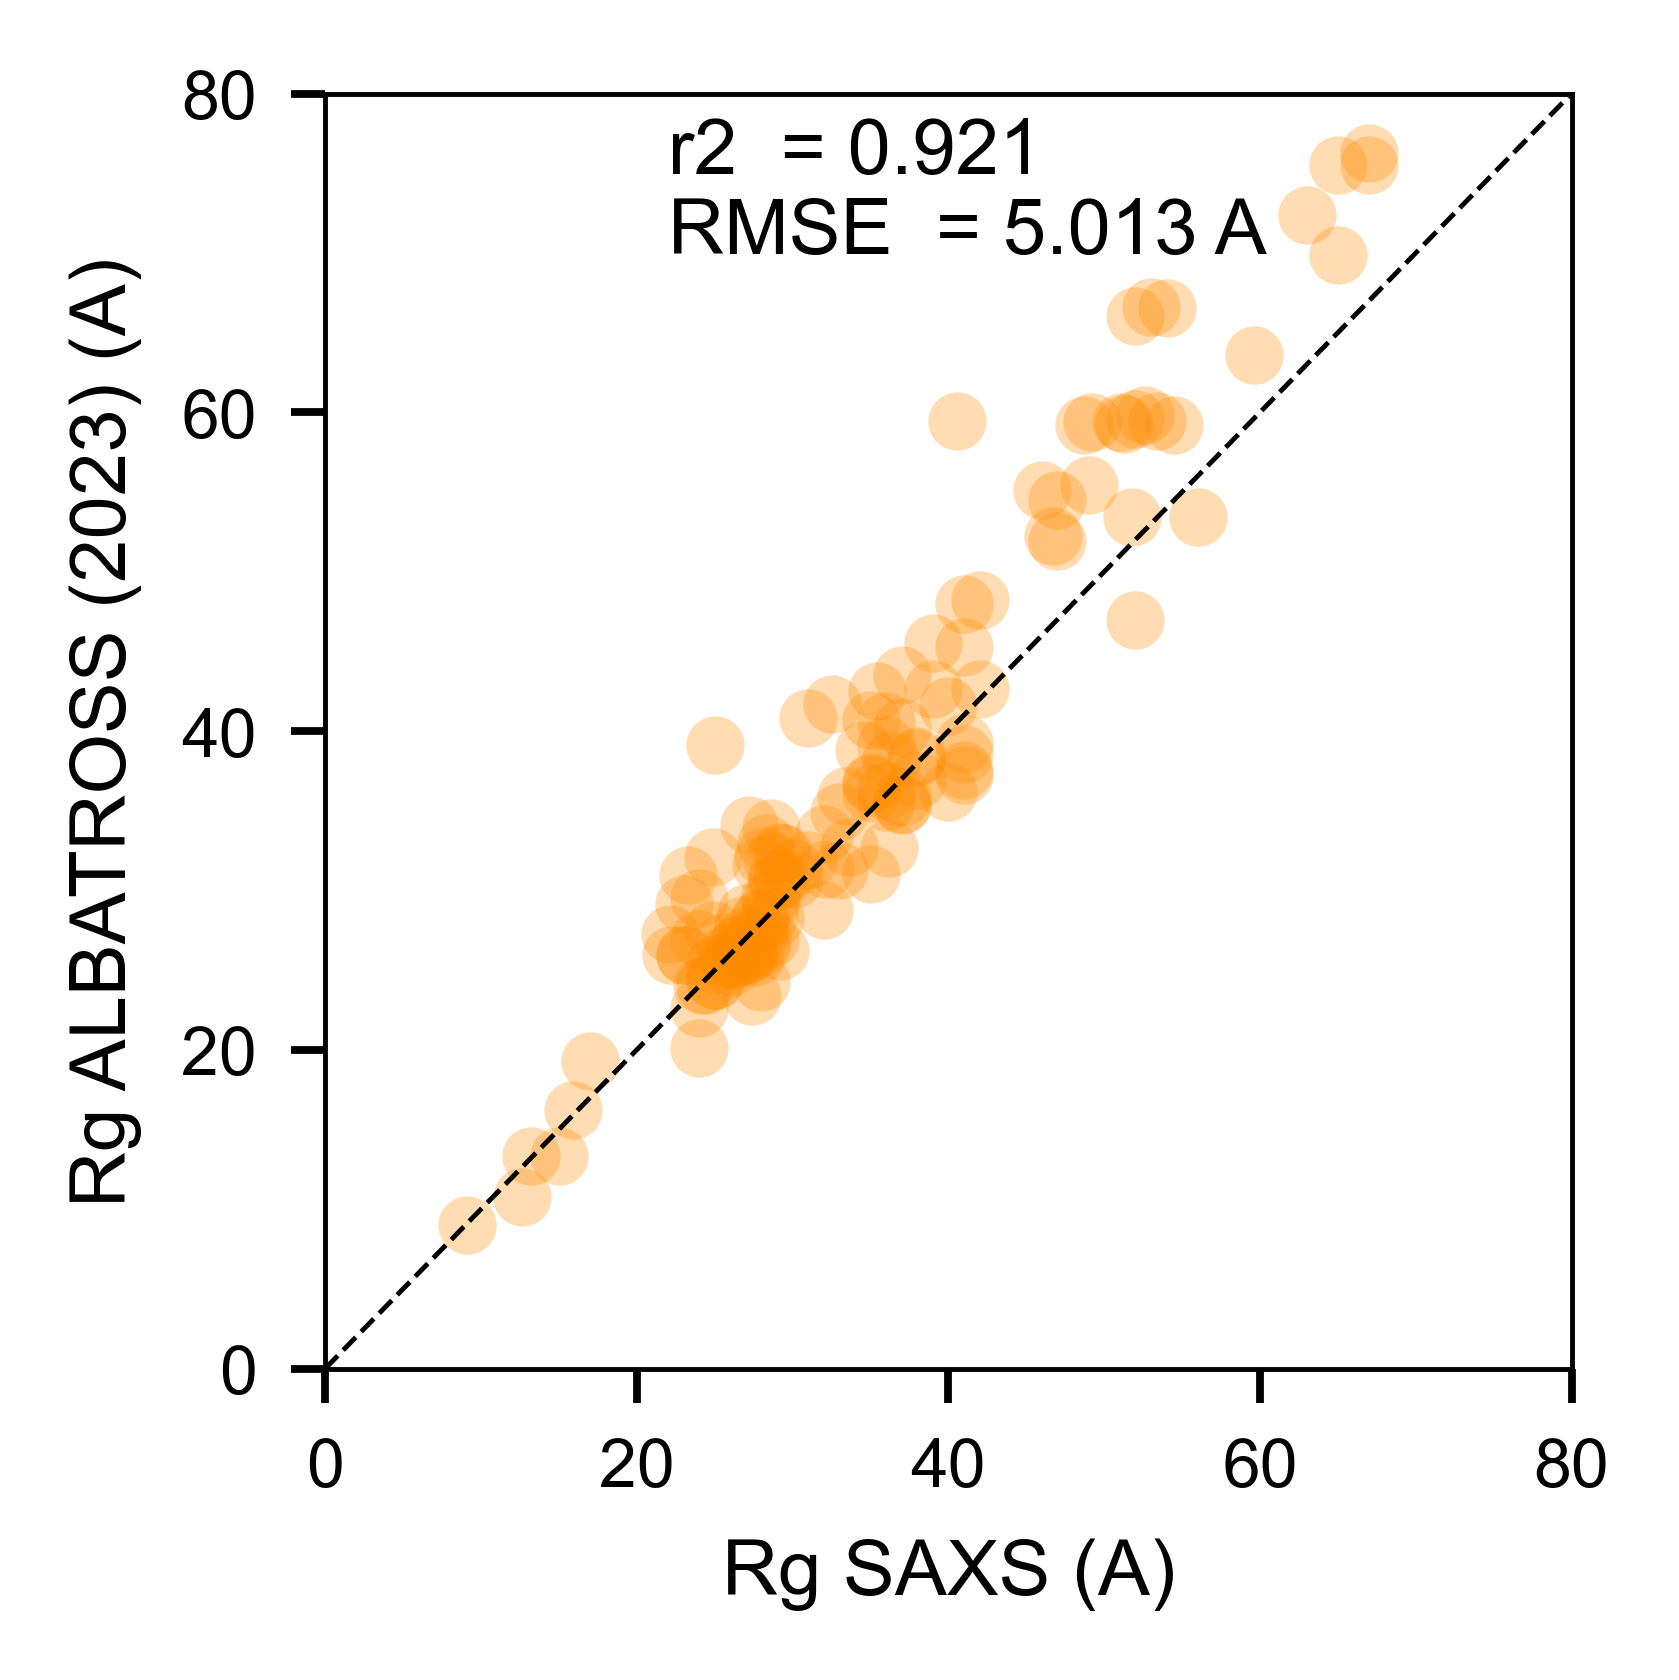

In [18]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = np.array(rg_prediction['ALBATROSS'])

plt.plot(d1, d2, '.', color='darkorange', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('rg_SAXS_ALBATROSS2.pdf')


## CALVADOS2 vs. SAXS

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/2237235283.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


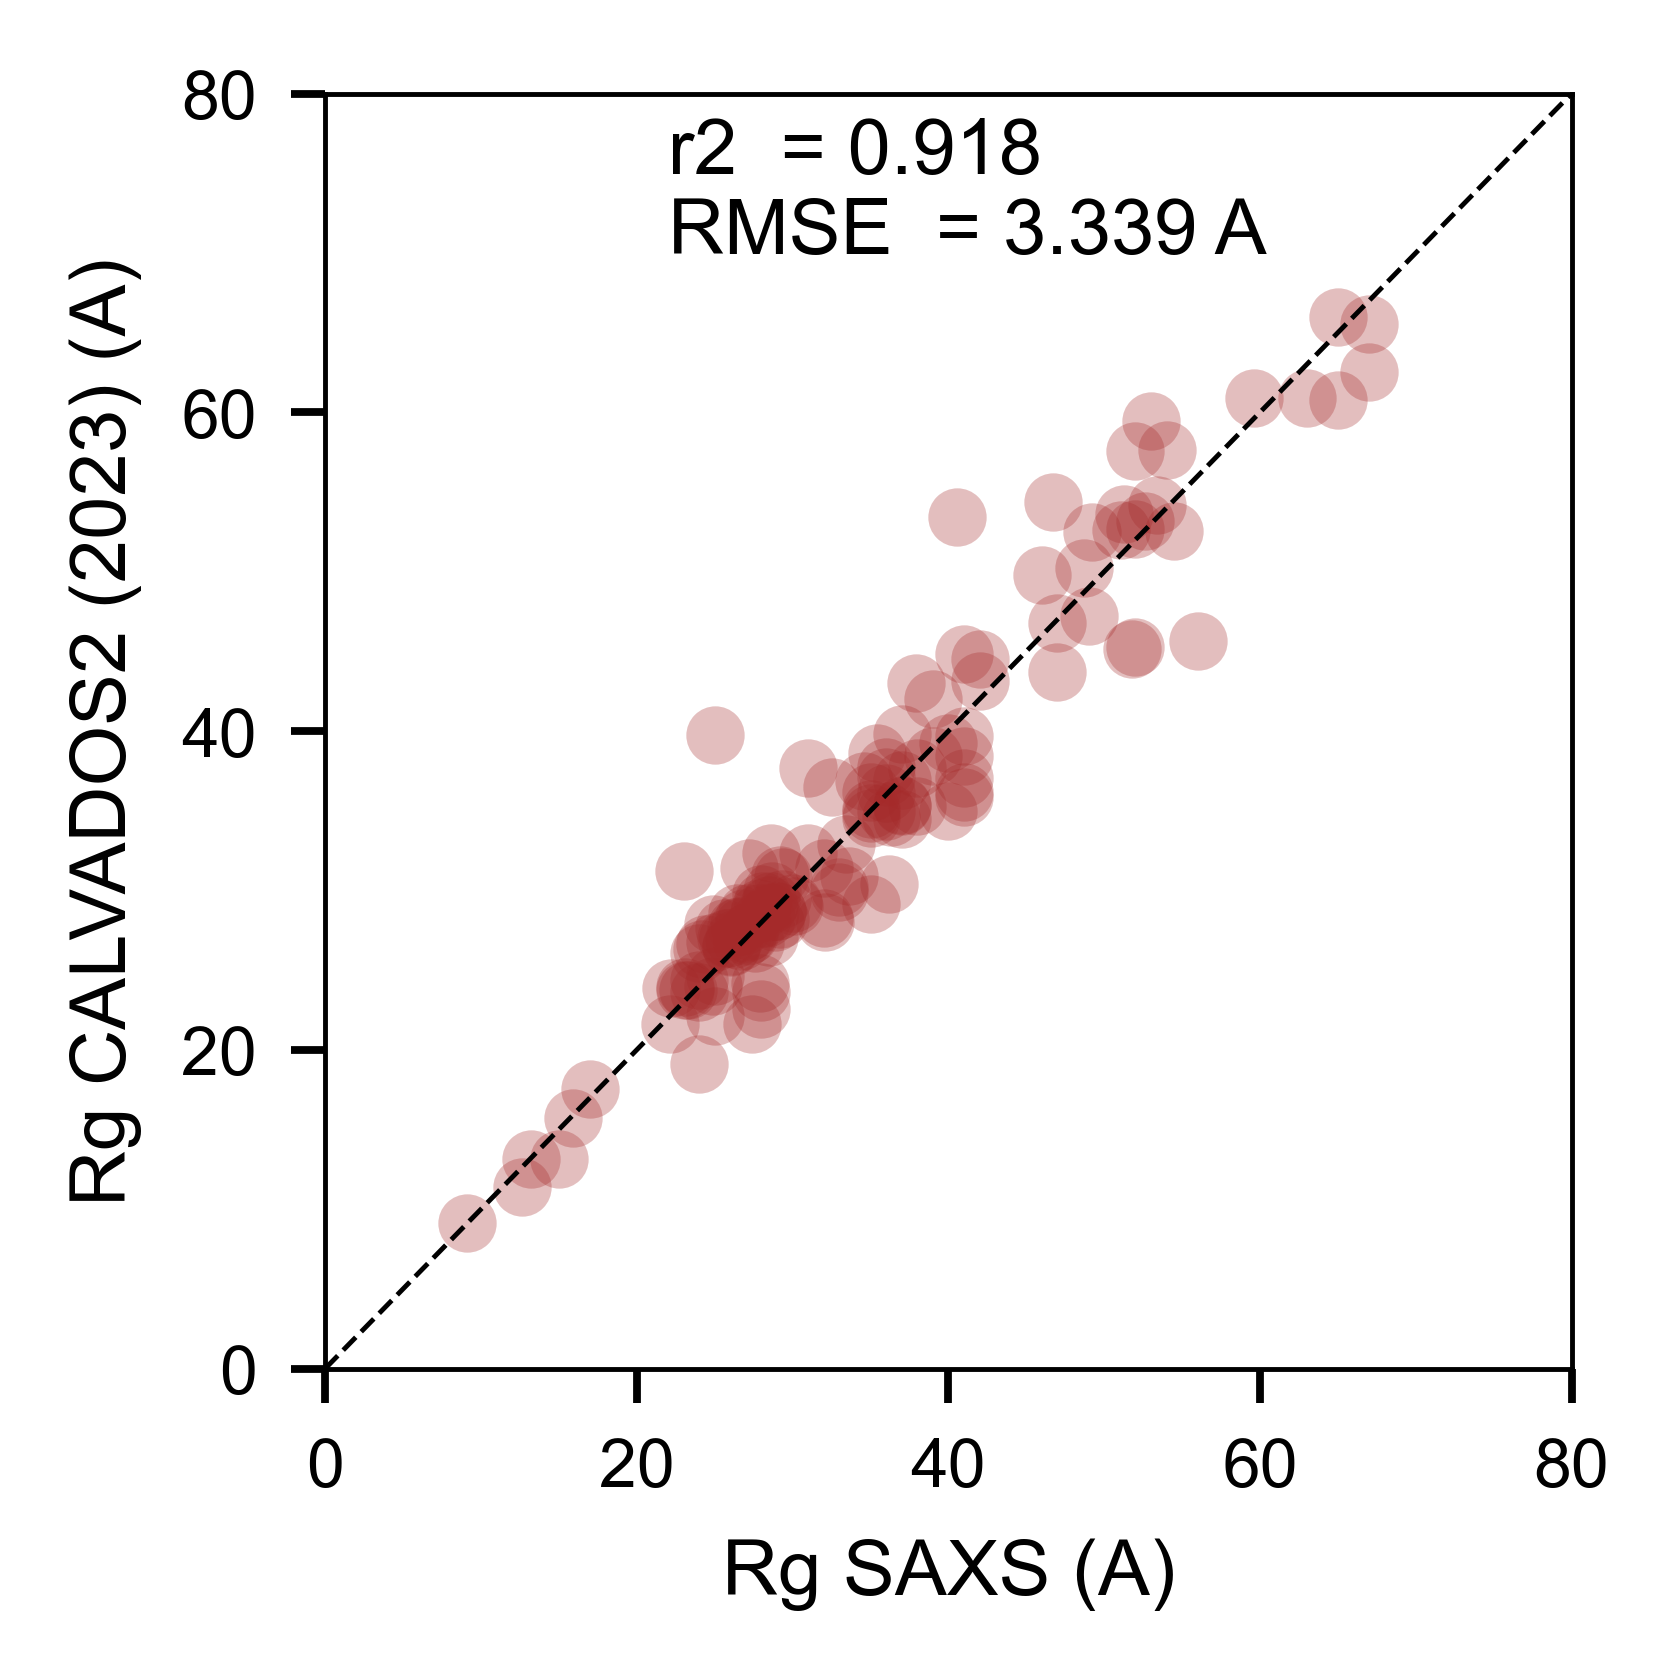

In [19]:
figure(None, (2.5,2.5), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = rg_prediction['CALVADOS2']


plt.plot(d1, d2, '.', color='brown', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg CALVADOS2 (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])


plt.tight_layout()
plt.savefig('rg_SAXS_CALVADOS2.pdf')


## ALBATROSS vs. Mpipi-GG

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/3627940623.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


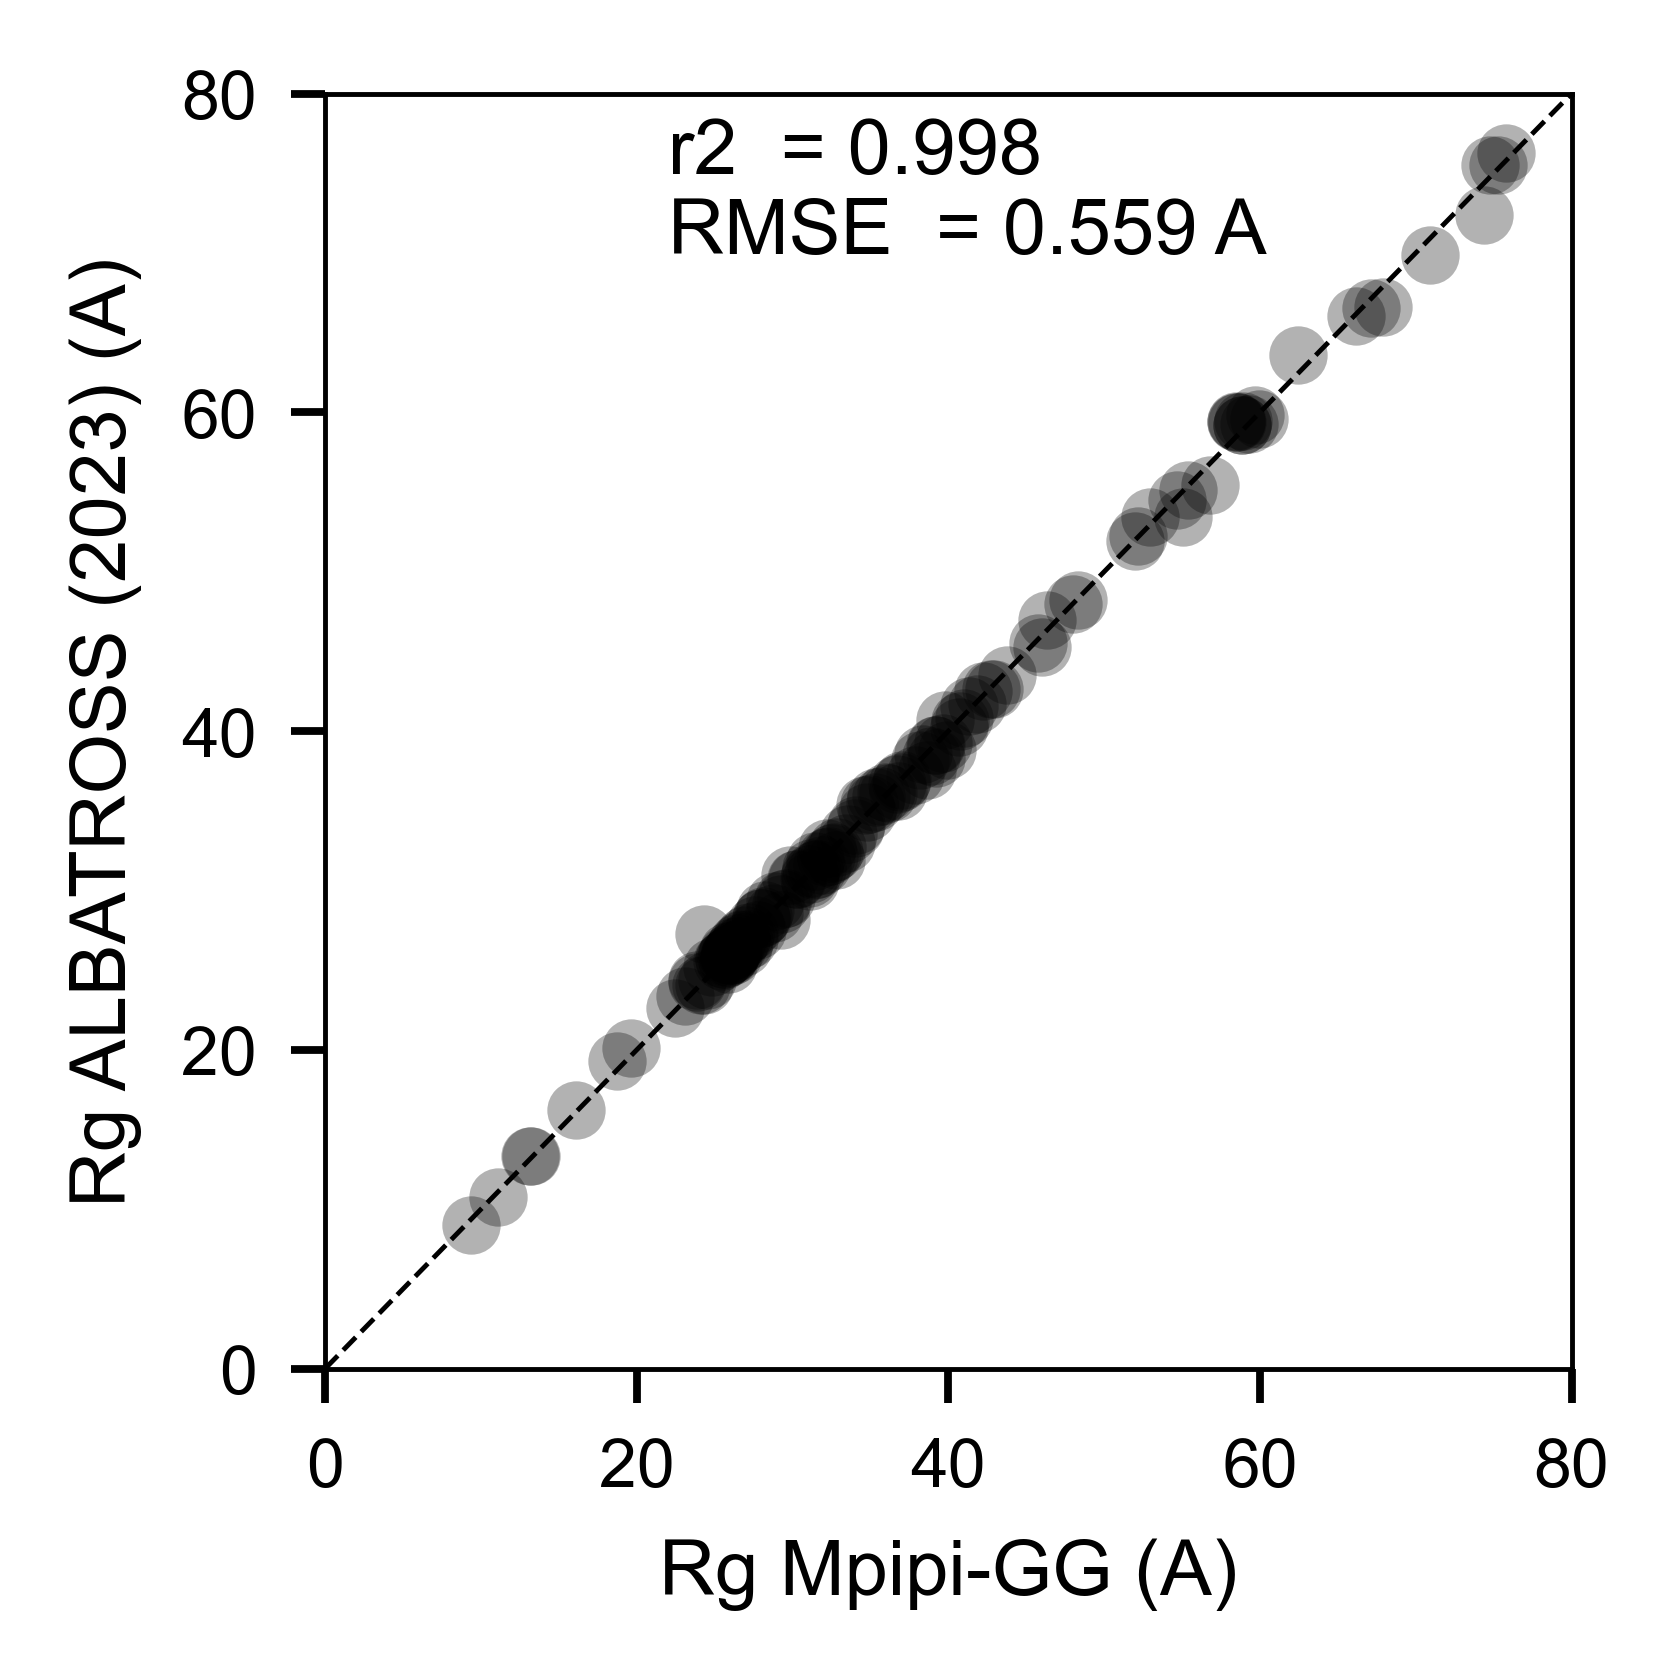

In [20]:
figure(None, (2.5,2.5), dpi=350)

d1 = LAMMPS_rg

d2 = np.array(rg_prediction['ALBATROSS']) 


plt.plot(d1, d2, '.', color='black', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg Mpipi-GG (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])



plt.tight_layout()
plt.savefig('MpipiGG_vs_ALBATROSS.pdf')


## ALBATROSS vs. CALVADOS2

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/2762023802.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


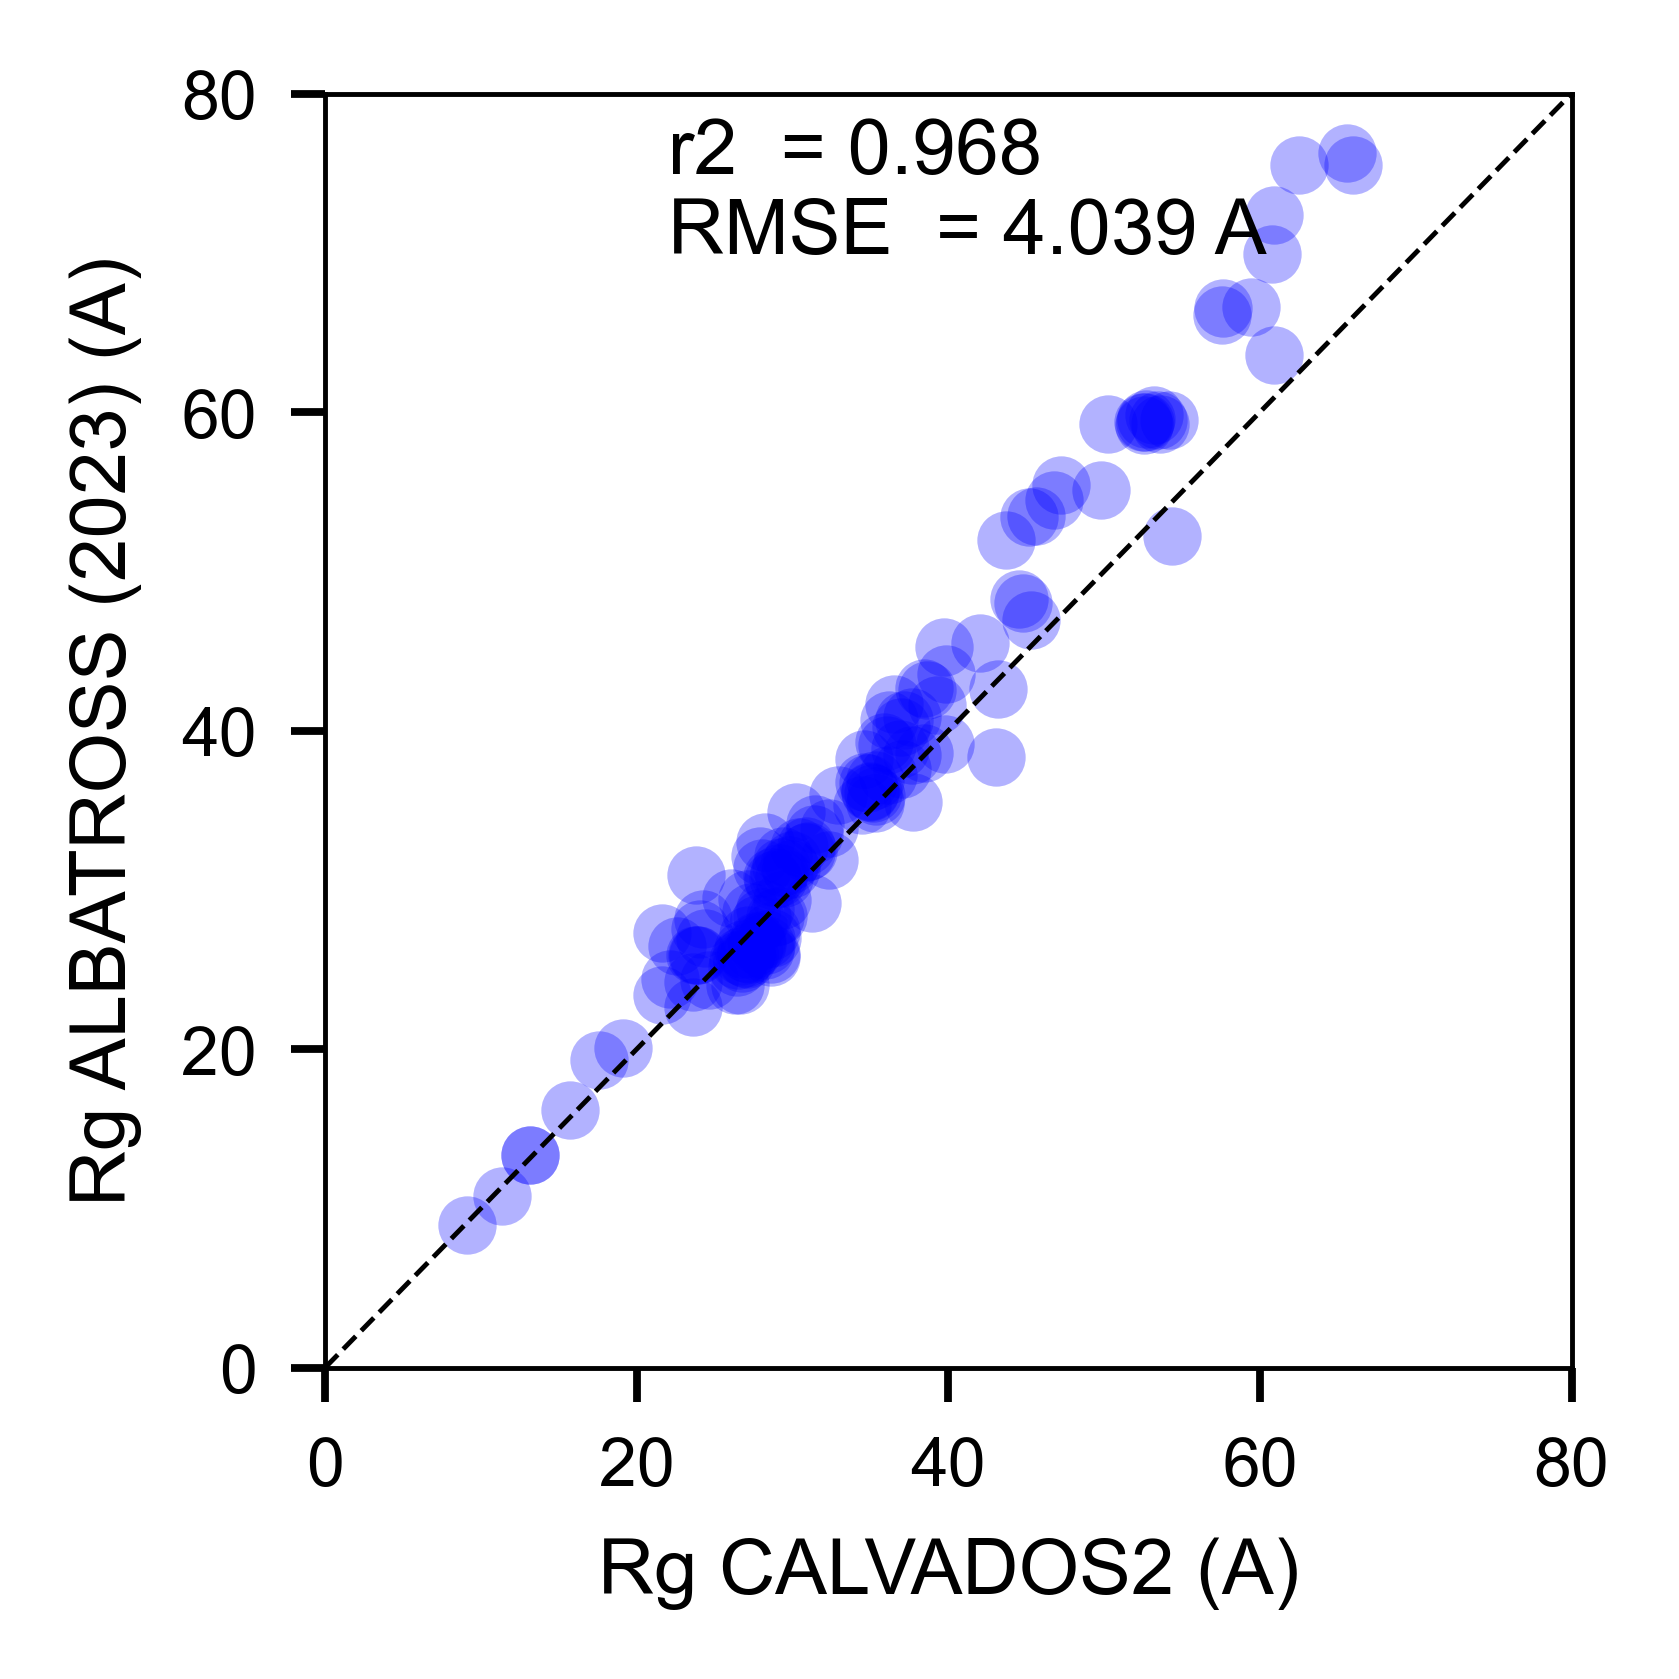

In [21]:
figure(None, (2.5,2.5), dpi=350)


d1 = np.array(rg_prediction['CALVADOS2'])
d2 = np.array(rg_prediction['ALBATROSS']) 





#plt.plot(d1, d2, '.', color='blue', ms=4, mew=0, alpha=0.8, mec='k',label='Mpipi-GG')


plt.plot(d1, d2, '.', color='blue', ms=12, mew=0, alpha=0.3, mec='k')
plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg CALVADOS2 (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (2023) (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(22, 75, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(22, 70, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('CALVADOS2_vs_ALBATROSS.pdf')


### Figure 1B
The code below generates the SAXS vs. ALBATROSS panel shown in Figure 1B

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_56620/175482512.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, frameon=False)


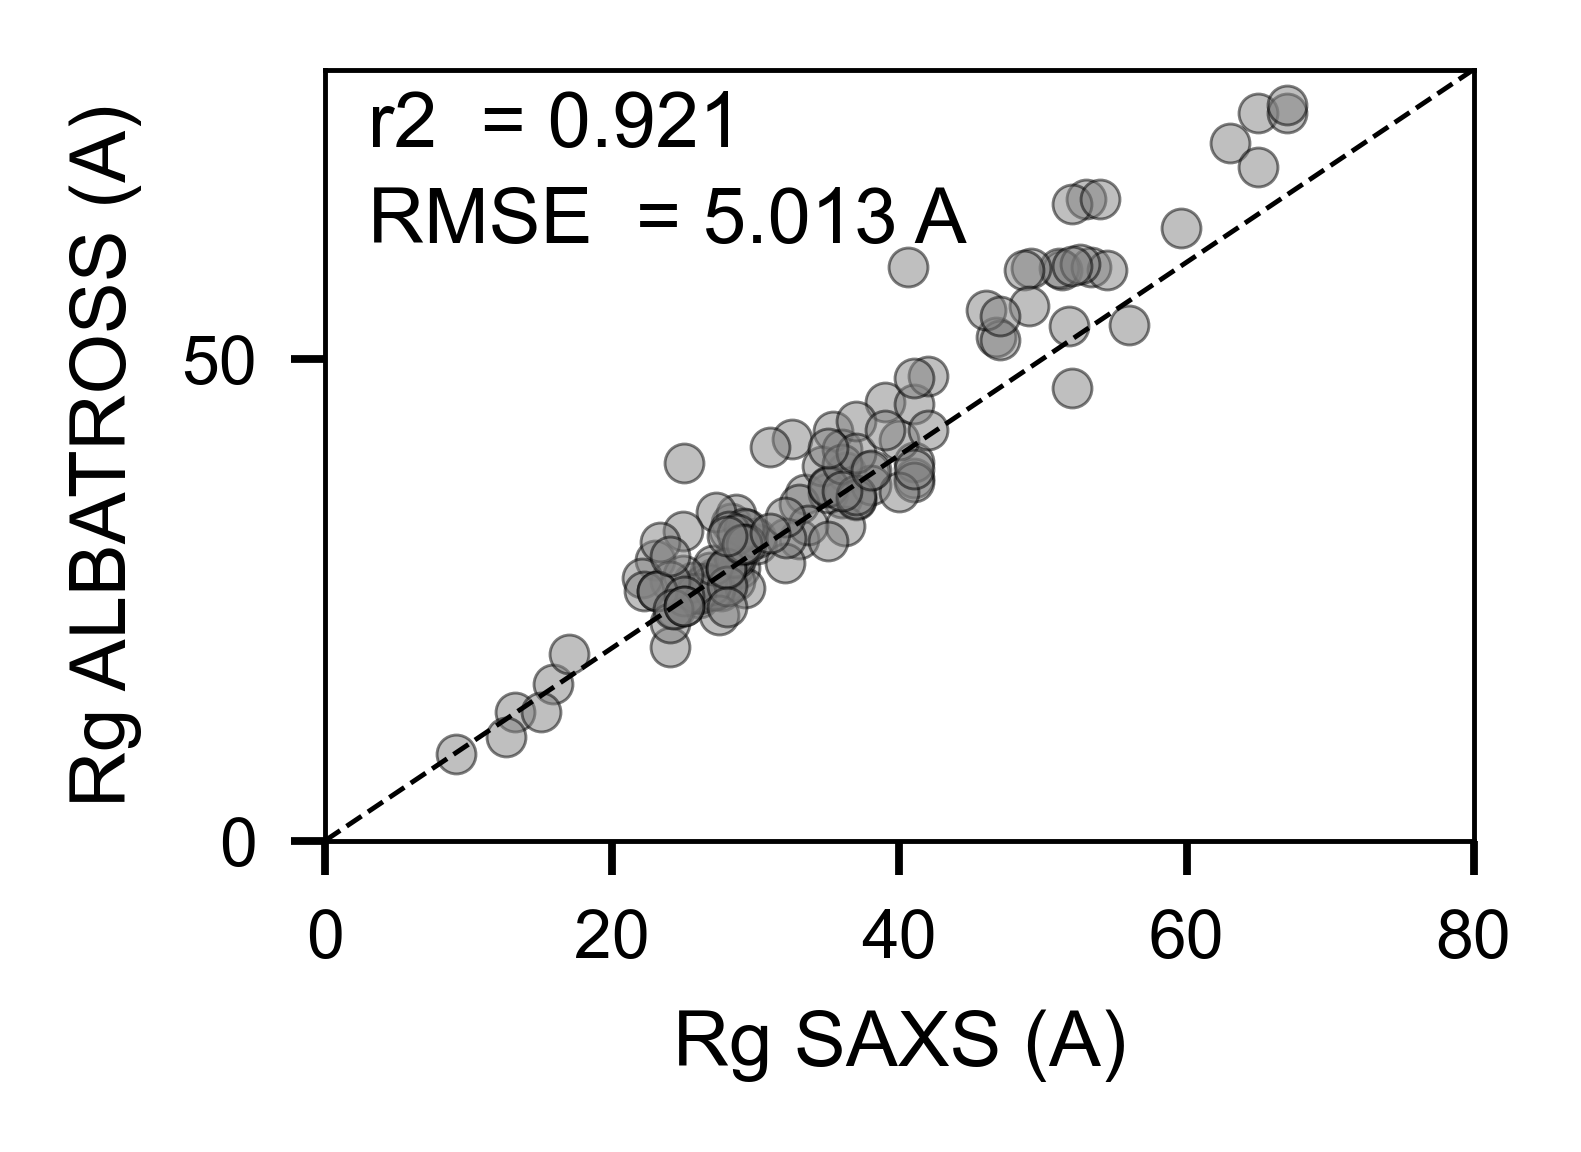

In [22]:
figure(None, (2.36, 1.78), dpi=350)

scaling_factor = 1

d1 = SAXS_rg
d2 = np.array(rg_prediction['ALBATROSS'])

plt.plot(d1, d2, '.', color='grey', ms=8, mew=0.3, alpha=0.5, mec='k')

plt.xticks(np.arange(0,140,20))
plt.xticks(np.arange(0,140,20))
plt.plot([0,120],[0,120],'--k', linewidth=0.5)
r2 = np.power(np.corrcoef(d1, d2)[0][1],2)
plt.legend(fontsize=6, frameon=False)

plt.xlabel('Rg SAXS (A)', fontsize=8)
plt.ylabel('Rg ALBATROSS (A)', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.text(3, 72, "r2 " +f" = {round(r2,3)}", fontsize=8)
plt.text(3, 62, r"RMSE " +f" = {round(calc_rmse(d1,d2),3)} A", fontsize=8)
plt.ylim([0,80])
plt.xlim([0,80])




plt.tight_layout()
plt.savefig('FIGURE_1_rg_SAXS_ALBATROSS2.pdf')
